In [55]:
from qutip.wigner import qfunc
from qst_nn.utils import plot_confusion_matrix, plot_husimi_directly
from qst_nn.ops import cat, num, thermal_dm, binomial, coherent_dm, fock_dm, gkp
from qst_nn.ops import random as ops_random
import qst_nn.ops

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

xgrid = 32
ygrid = 32

xvec = np.linspace(-5, 5, xgrid)
yvec = np.linspace(-5, 5, ygrid)
g_scale = 2

fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {# 'backend': 'ps',
          'axes.labelsize': 8,
          'font.size': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.labelpad': 1,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
figpath = "figures/"


class Data_generator():
    '''
    Data generator for training and testing
    state_gen(): generate state
    dataset_gen(): generate dataset
    '''
    def __init__(self):
        self.label_map = {'fock_dm': 0,
                          'coherent_dm':1,
                          'thermal_dm':2,
                          'num':3,
                          'binomial':4,
                          'cat':5,
                          'gkp':6,
                          'ops_random':7}
        
        self.function_list = [fock_dm, coherent_dm, thermal_dm, 
                              num, binomial, cat, gkp, ops_random]
    
    def state_gen(self,
                  state=None,
                  random_mode=True,
                  get_label=True,
                  num_samples=1):
        
        '''
        state(string): determine output state type (choose from label_map or function_list), 
                        no effect if random_mode set to True.
        random_mode(bool): if set True, all state generated is randomly selected from function list. 
                        If False, all state will be determined by state variable.
        get_label(bool): output return label according to label map by the 
                        form of [state(numpy array), label(int)]
        num_samples(int): number of output samples, stored in a numpy array by default.
        '''
        #Random mode
        if random_mode:
            #labeled data
            if get_label:
                if num_samples <= 1:
                    func = np.random.choice(self.function_list)
                    label = self.label_map.get(func.__name__)
                    return np.array([qfunc(func(32)[0], xvec, yvec, g=g_scale), label], dtype=object)
                else:
                    state_list = np.array([], dtype=object)
                    for _ in np.arange(num_samples):
                        func = np.random.choice(self.function_list)
                        label = self.label_map.get(func.__name__)
                        np.concatenate((state_list, [qfunc(func(32)[0], xvec, yvec, g=g_scale), label]))
                    return state_list
                
            #None labeled data
            else:
                if num_samples <= 1:
                    return qfunc(np.random.choice(self.function_list)(32)[0], 
                                 xvec, yvec, g=g_scale)
                else:
                    state_list = []
                    for _ in np.arange(num_samples):
                        func = np.random.choice(self.function_list)
                        state_list.append(qfunc(func(32)[0], xvec, yvec, g=g_scale))
                    return np.array(state_list)

                
        #Static mode
        else:
            for function in self.function_list:
                if state == function.__name__:
                    func = function
                    break;
                else:
                    raise Exception('State not included in function list')
            #labeled data     
            if get_label:
                label = self.label_map.get(func.__name__)
                if label == None:
                    raise Exception('Label return None, cannnot determine function.')
                if num_samples <= 1:
                    return np.array([qfunc(func(32)[0], xvec, yvec, g=g_scale), label] , dtype=object)
                else:
                    return np.array([[qfunc(func(32)[0], xvec, yvec, g=g_scale), label] 
                                     for _ in np.arange(num_samples)], dtype=object)
            #None labeled data
            else:
                if num_samples <= 1:
                    return qfunc(func(32)[0], xvec, yvec, g=g_scale)
                else:
                    return np.array([qfunc(func(32)[0], xvec, yvec, g=g_scale) 
                                    for _ in np.arange(num_samples)])
            
            
        
    def dataset_gen(self,
                    dataset_size=10000,
                    train_split=0.8,
                    to_file = True,
                    train_file_dir='./oqt_train.npy',
                    test_file_dir='./oqt_test.npy'):
        
        train_size = round(dataset_size*train_split)
        test_size = dataset_size-train_size
        train_set = []
        test_set = []
        
        for _ in np.arange(train_size):
            label = np.random.randint(8)
            train_set.append([self.state_gen(self.label_map.get(label)), label])
        
        train_set = np.array(train_set, dtype=object)
        
        if to_file: 
            np.save(train_file_dir, train_set)
        
        for _ in np.arange(test_size):
            label = np.random.randint(7)
            test_set.append([self.state_gen(self.label_map.get(label)), label])
            
        test_set = np.array(test_set, dtype=object)

        if to_file: 
            np.save(test_file_dir, test_set)
            
        return train_set, test_set
      
data_gen = Data_generator()
x = data_gen.state_gen(num_samples=10)
print(x)
#fig, ax = plot_husimi_directly(x, cmap='hot')
#plt.show

[]


<function matplotlib.pyplot.show(close=None, block=None)>

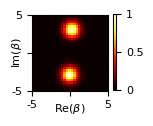

In [14]:
x = data_gen.single_state_gen()
fig, ax = plot_husimi_directly(x, cmap='hot')
plt.show

In [33]:
print(data_gen.state_gen('fock_dm'))

[[array([[1.20352682e-10, 1.18095139e-09, 9.44759130e-09, ...,
          9.44759130e-09, 1.18095139e-09, 1.20352682e-10],
         [1.18095139e-09, 1.09374403e-08, 8.22711233e-08, ...,
          8.22711233e-08, 1.09374403e-08, 1.18095139e-09],
         [9.44759130e-09, 8.22711233e-08, 5.79127114e-07, ...,
          5.79127114e-07, 8.22711233e-08, 9.44759130e-09],
         ...,
         [9.44759130e-09, 8.22711233e-08, 5.79127114e-07, ...,
          5.79127114e-07, 8.22711233e-08, 9.44759130e-09],
         [1.18095139e-09, 1.09374403e-08, 8.22711233e-08, ...,
          8.22711233e-08, 1.09374403e-08, 1.18095139e-09],
         [1.20352682e-10, 1.18095139e-09, 9.44759130e-09, ...,
          9.44759130e-09, 1.18095139e-09, 1.20352682e-10]])    0]
 [array([[7.67425181e-20, 1.53037147e-18, 2.47990381e-17, ...,
          2.47990381e-17, 1.53037147e-18, 7.67425181e-20],
         [1.53037147e-18, 3.02480427e-17, 4.85532986e-16, ...,
          4.85532986e-16, 3.02480427e-17, 1.53037147e-18],
   